#### Load libraries


In [1]:
import os
from os.path import join as pjoin

import numpy as np
import pandas as pd
import PyComplexHeatmap as pch
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import QuantileTransformer

from omics_tools import association
from omics_tools import enrichment, multivariate, preprocessing


#### Load data

In [2]:
DATA_DIRECTORY = "/Users/ar3513/Code/data/"

In [3]:
data = pd.read_parquet(pjoin(DATA_DIRECTORY, "uc_gse109142_data.parquet")).set_index("sample_id")
data = data[data.columns[(data.median() > 0.02)]] # remove very lowly expressed genes

metadata = pd.read_parquet(pjoin(DATA_DIRECTORY, "uc_gse109142_metadata.parquet")).set_index("sample_id")

pathways = pd.read_parquet(pjoin(DATA_DIRECTORY, "pathways.parquet"))
pathways = pathways.query('pathway_name.str.contains("disease") == False', engine='python')
pathway_mapper = pathways.groupby("pathway_name")["gene_name"].apply(set).to_dict()


#### Data processing

In [4]:
# Quantile-transformation of data
data_qt = preprocessing.quantile_transformation(data=data, n_quantiles=100)

# Inverse-normal transformation
data_normalised = preprocessing.inverse_normal_transformation(data=data)


#### Quick QC based on PCA

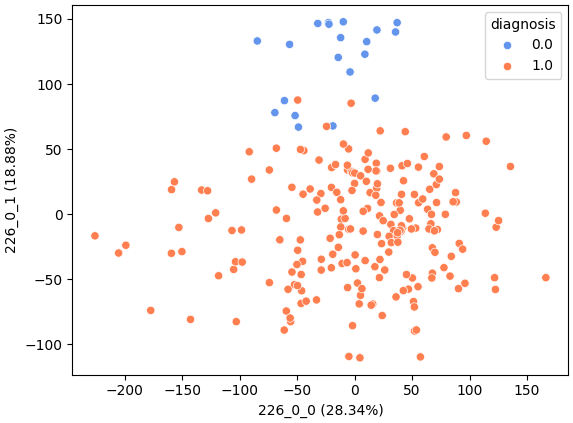

In [5]:
# PCA model
pca_model = multivariate.pca(data=data_normalised, n_components=np.min(data.shape), scale=True)

# Select components for plotting
PC_x = '226_0_0'
PC_y = '226_0_1'

# Get variance proportion of explained by PC_x and PC_y
var_x = np.round((pca_model.explained_variance_ratio.query(f"component == '{PC_x}'")["var"]*100).iloc[0], 2)
var_y = np.round((pca_model.explained_variance_ratio.query(f"component == '{PC_y}'")["var"]*100).iloc[0], 2)

# Plot the sample weights for the first two PCA components
sns.scatterplot(data=pca_model.sample_weights.join(metadata), 
                x=PC_x, 
                y=PC_y, 
                hue='diagnosis', 
                palette=
                {
                    0: 'cornflowerblue',
                    1: 'coral'
                }
               )

# Add labels and title
plt.xlabel(f"{PC_x} ({var_x}%)")
plt.ylabel(f"{PC_y} ({var_y}%)")

plt.show()



#### Association analysis

In [6]:
DIAGNOSIS_COLUMN = "diagnosis"
COVARIATE_COLUMNS = ["age_at_diagnosis", "sex"]
SEVERITY_COLUMNS = ["total_mayo_score", "histology_severity_score"]


##### A) Case-control without covariate adjustment

In [7]:
%time 

associations_case_control = association.compare_distributions(
    continuous_variables=data,
    binary_variable=metadata["diagnosis"],
    method_category=association.AssociationMethodCategory.NON_PARAMETRIC,
    alternative_hypothesis=association.AlternativeHypothesis.TWO_SIDED,
    min_group_size=2,
)

associations_case_control.sort_values("pvalue").head()


CPU times: user 3 μs, sys: 1e+03 ns, total: 4 μs
Wall time: 11.2 μs


,feature,avg_group,avg_not_group,avg_group_ratio,pvalue,pfdr
3059,CSF3R,14.39815,0.938255,15.345668,1.616670e-13,2.403067e-11
5931,HSH2D,24.47615,8.726250,2.804888,1.616670e-13,2.403067e-11
6365,ITGAX,18.54955,1.746200,10.622810,1.660729e-13,2.403067e-11
609,ANKRD13D,17.92740,5.389350,3.326449,1.660729e-13,2.403067e-11
4630,FCRL5,21.53445,1.630700,13.205648,1.660729e-13,2.403067e-11


##### B) Case-control with covariate adjustment

In [8]:
%%time

associations_case_control_adjusted = association.regression(
    independent_variables=data, 
    dependent_variable=metadata[DIAGNOSIS_COLUMN], 
    covariates=metadata[COVARIATE_COLUMNS], 
    regression_method=association.RegressionMethod.LOGISTIC
).assign(feature_y=DIAGNOSIS_COLUMN)

associations_case_control_adjusted.sort_values("pvalue").head()


/Users/ar3513/Code/omics_tools/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ar3513/Code/omics_tools/.venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/ar3513/Code/omics_tools/.venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Users/ar3513/Code/omics_tools/src/omics_tools/association.py:502: UserWarning: Regression failed for CCDC88B and y: Singular matrix
  warnings.warn(
/Users/ar3513/Code/omics_tools/.venv/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/ar3513/Code/omics_tools/.

CPU times: user 14.3 s, sys: 946 ms, total: 15.3 s
Wall time: 39.7 s


,feature_y,feature_x,beta,se,pvalue,pfdr
0,diagnosis,PIGZ,-0.166612,0.027805,2.069412e-09,0.000002
0,diagnosis,CA2,-0.006388,0.001071,2.458232e-09,0.000002
0,diagnosis,SCIN,-0.216302,0.036472,3.019009e-09,0.000002
0,diagnosis,PDXP,-0.829146,0.140150,3.295871e-09,0.000002
0,diagnosis,PLLP,-0.268294,0.045596,4.002241e-09,0.000002


##### C) Disease severity (total_mayo_score, histology_severity_score)

In [9]:
%time 

associations_severity = association.correlation(
    continuous_variables_a=data, 
    continuous_variables_b=metadata[SEVERITY_COLUMNS], 
    method_category=association.AssociationMethodCategory.NON_PARAMETRIC
)

associations_severity.sort_values("pvalue").head()


CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 9.06 μs


,feature_a,feature_b,r,pvalue,pfdr
0,S100A12,total_mayo_score,0.630694,3.013280e-24,4.663352e-20
0,MCEMP1,total_mayo_score,0.615196,7.719605e-23,5.973430e-19
0,S100A8,total_mayo_score,0.608941,2.718352e-22,1.402307e-18
0,PCK1,total_mayo_score,-0.591257,8.249229e-21,3.191627e-17
0,TRPM6,total_mayo_score,-0.569395,4.242590e-19,9.973834e-16


In [10]:
%time 

associations_severity_fast = association.fast_linear_regression(
    independent_variables=data_normalised,
    dependent_variables=metadata[SEVERITY_COLUMNS], 
    covariates=metadata[COVARIATE_COLUMNS]
)

associations_severity_fast.sort_values("pvalue").head()


CPU times: user 4 μs, sys: 1 μs, total: 5 μs
Wall time: 9.06 μs


,feature_x,feature_y,beta,se,statistic,pvalue,pfdr
11306,S100A12,total_mayo_score,1.750372,0.169980,10.297487,4.073882e-20,6.304739e-16
9271,PCK1,total_mayo_score,-1.688793,0.165695,-10.192185,8.257644e-20,6.389765e-16
11317,S100A8,total_mayo_score,1.722642,0.172349,9.995080,3.081533e-19,1.589660e-15
7510,MCEMP1,total_mayo_score,1.690311,0.172415,9.803740,1.098275e-18,4.249224e-15
2590,CKB,total_mayo_score,-1.613846,0.165639,-9.743139,1.639915e-18,5.075864e-15


##### D) Disease severity with covariate adjustment

In [11]:
%time 

associations_severity_adjusted = association.regression(
    independent_variables=data_normalised,
    dependent_variable=metadata[SEVERITY_COLUMNS[0]], # one severity column at a time (total_mayo_score)
    covariates=metadata[COVARIATE_COLUMNS],
    regression_method=association.RegressionMethod.LINEAR
).assign(feature_y=SEVERITY_COLUMNS[0])

associations_severity_adjusted.sort_values("pvalue").head()


CPU times: user 2 μs, sys: 2 μs, total: 4 μs
Wall time: 6.91 μs


,feature_y,feature_x,beta,se,pvalue,pfdr
0,total_mayo_score,S100A12,1.745883,0.161657,9.348980e-22,1.446848e-17
0,total_mayo_score,S100A8,1.736114,0.165715,8.641278e-21,6.686621e-17
0,total_mayo_score,PCK1,-1.687865,0.163702,2.685521e-20,1.161633e-16
0,total_mayo_score,MCEMP1,1.702165,0.165352,3.002411e-20,1.161633e-16
0,total_mayo_score,CKB,-1.614019,0.162706,3.794484e-19,1.174469e-15


In [12]:
%time 

associations_severity_adjusted_fast = association.fast_linear_regression(
    independent_variables=data_normalised,
    dependent_variables=metadata[SEVERITY_COLUMNS], 
    covariates=metadata[COVARIATE_COLUMNS]
)

associations_severity_adjusted_fast.sort_values("pvalue").head()


CPU times: user 3 μs, sys: 2 μs, total: 5 μs
Wall time: 9.06 μs


,feature_x,feature_y,beta,se,statistic,pvalue,pfdr
11306,S100A12,total_mayo_score,1.750372,0.169980,10.297487,4.073882e-20,6.304739e-16
9271,PCK1,total_mayo_score,-1.688793,0.165695,-10.192185,8.257644e-20,6.389765e-16
11317,S100A8,total_mayo_score,1.722642,0.172349,9.995080,3.081533e-19,1.589660e-15
7510,MCEMP1,total_mayo_score,1.690311,0.172415,9.803740,1.098275e-18,4.249224e-15
2590,CKB,total_mayo_score,-1.613846,0.165639,-9.743139,1.639915e-18,5.075864e-15


#### Enrichment analysis

In [13]:
PVAL_THRESHOLD = 0.001
FC_THRESHOLD = 1.5


In [14]:
top_genes_case_control = associations_case_control.query("pfdr < @PVAL_THRESHOLD & (avg_group_ratio > @FC_THRESHOLD | avg_group_ratio < 1/@FC_THRESHOLD)")
pathways_enriched_case_control = enrichment.fisher(query=set(top_genes_case_control["feature"]), 
                                                   annotation_mapper=pathway_mapper, 
                                                   space_size=data.shape[1]
                                                  )
pathways_enriched_case_control.sort_values("pfdr").head(6)


,query,annotation_id,overlap,query_length,annotation_length,overlap_length,pvalue,pfdr
77,"{EPHX1, EVA1B, PPP2R3A, IMPG1, FHL5, SLC9C1, C...",Cytokine-cytokine receptor interaction,"{CX3CL1, MPL, CCL3L3, IL7, GHR, INHBA, CXCL11,...",5983,298,176,5.310880e-13,1.842875e-10
140,"{EPHX1, EVA1B, PPP2R3A, IMPG1, FHL5, SLC9C1, C...",Hematopoietic cell lineage,"{CD44, IL4, CR1L, IL1R1, IL7, HLA-DOA, FLT3, F...",5983,99,68,1.269785e-09,2.203076e-07
329,"{EPHX1, EVA1B, PPP2R3A, IMPG1, FHL5, SLC9C1, C...",Viral protein interaction with cytokine and cy...,"{IL20, CXCL5, CXCR5, CX3CL1, CCL13, TNFSF14, C...",5983,100,68,2.471840e-09,2.859095e-07
54,"{EPHX1, EVA1B, PPP2R3A, IMPG1, FHL5, SLC9C1, C...",Cell adhesion molecules,"{CLDN18, SDC4, NTNG1, NTNG2, PECAM1, SELL, HLA...",5983,157,91,6.815254e-07,5.912233e-05
271,"{EPHX1, EVA1B, PPP2R3A, IMPG1, FHL5, SLC9C1, C...",Rheumatoid arthritis,"{TGFB1, MMP1, CXCL5, CXCL8, CCL3L3, HLA-DOA, I...",5983,94,59,1.828884e-06,1.269246e-04
302,"{EPHX1, EVA1B, PPP2R3A, IMPG1, FHL5, SLC9C1, C...",Th17 cell differentiation,"{JAK3, TGFB1, NFATC1, AHR, RUNX1, IL4, IL1R1, ...",5983,108,65,4.568243e-06,2.641967e-04


In [15]:
top_genes_severity = set(associations_severity_fast.query("pfdr < @PVAL_THRESHOLD")["feature_x"])
pathways_enriched_severity = enrichment.fisher(query=top_genes_severity, 
                                               annotation_mapper=pathway_mapper, 
                                               space_size=data.shape[1]
                                              )
pathways_enriched_severity.sort_values("pfdr").head(6)


,query,annotation_id,overlap,query_length,annotation_length,overlap_length,pvalue,pfdr
273,"{EPHX1, STEAP1, EVA1B, BDH1, EDN3, KLC4, PPP2R...",Ribosome,"{RPL32, RPL15, MRPL11, RPL19, RPS27A, MRPL16, ...",2946,172,81,4.488866e-17,1.557636e-14
183,"{EPHX1, STEAP1, EVA1B, BDH1, EDN3, KLC4, PPP2R...",Metabolic pathways,"{PLCE1, GSS, BDH1, ACOX2, CYC1, UQCRB, GYG1, G...",2946,1562,382,1.315919e-08,2.283120e-06
303,"{EPHX1, STEAP1, EVA1B, BDH1, EDN3, KLC4, PPP2R...",Thermogenesis,"{NPR1, COX11, NDUFB8, NDUFS4, NDUFA8, PRKACB, ...",2946,235,76,6.902734e-07,4.790498e-05
82,"{EPHX1, STEAP1, EVA1B, BDH1, EDN3, KLC4, PPP2R...",Diabetic cardiomyopathy,"{TGFB1, NDUFB8, NDUFS4, NDUFA8, NDUFV1, UQCRC1...",2946,205,69,4.285929e-07,4.790498e-05
217,"{EPHX1, STEAP1, EVA1B, BDH1, EDN3, KLC4, PPP2R...",Oxidative phosphorylation,"{COX11, NDUFB8, NDUFS4, NDUFA8, ATP6V0D1, NDUF...",2946,138,51,5.773413e-07,4.790498e-05
230,"{EPHX1, STEAP1, EVA1B, BDH1, EDN3, KLC4, PPP2R...",Peroxisome,"{ACOX2, PXMP2, PEX26, ACOT8, PRDX5, ABCD3, PEX...",2946,83,35,9.940227e-07,5.748764e-05


#### Visualisations

##### A) Volcano plot

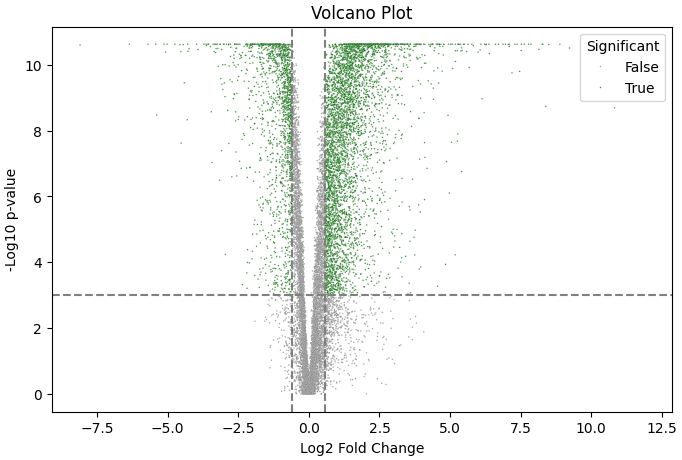

In [16]:
# Prepare data for plotting
tmp = associations_case_control.assign( 
    log10_pval=lambda x: -np.log10(x["pfdr"]), 
    log2_fc=lambda x: np.log2(x["avg_group_ratio"])
)

# Create the volcano plot
plt.figure(figsize=(8, 5))
volcano_plot = sns.scatterplot(
    data=tmp,
    x='log2_fc',
    y='log10_pval',
    hue=(tmp['log2_fc'].abs() > np.log2(FC_THRESHOLD)) & (tmp['log10_pval'] > -np.log10(PVAL_THRESHOLD)),
    palette={
        True: 'darkgreen', 
        False: 'gray'
    },
    alpha=0.7,
    s=1.2
)

# Add vertical and horizontal lines for thresholds
plt.axhline(y=-np.log10(PVAL_THRESHOLD), color='grey', linestyle='--')
plt.axvline(x=np.log2(FC_THRESHOLD), color='grey', linestyle='--')
plt.axvline(x=-np.log2(FC_THRESHOLD), color='grey', linestyle='--')

# Add labels and title
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 p-value')
plt.title('Volcano Plot')
plt.legend(title='Significant', loc='upper right')

# Display the plot
plt.show()


##### B) Heatmap of pathway genes

In [17]:
PATHWAY_NAME = "Oxidative phosphorylation"


In [18]:
pathway_genes = list(pathway_mapper[PATHWAY_NAME] & set(data.columns))


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Estimated legend width: 23.6375 mm


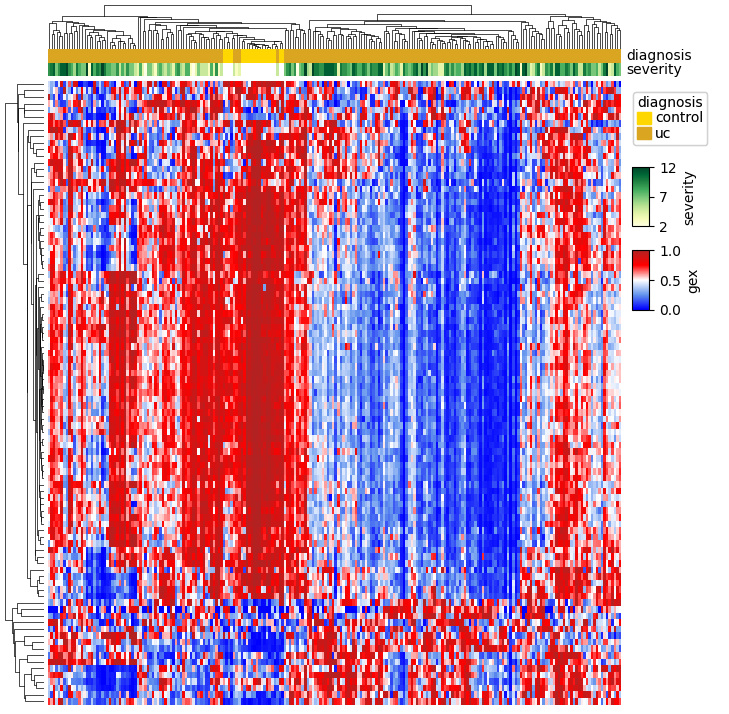

In [19]:
# Custome color palette for heatmap
color_names = ['blue', 'cornflowerblue', 'white', 'red', 'firebrick']

# Map the color names to RGB tuples using matplotlib's color dictionary
colors = [mcolors.to_rgb(color) for color in color_names]
nodes = list(np.arange(0, 1.25, 0.25))
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", list(zip(nodes, colors)))

# Annotation for samples
col_ha = pch.HeatmapAnnotation(
    diagnosis=pch.anno_simple(
        metadata[DIAGNOSIS_COLUMN].map({0: 'control', 1: 'uc'}),
        colors={'control': 'gold', 'uc': 'goldenrod'},
        #add_text=True,
        legend=True
    ), 
    severity=pch.anno_simple(metadata[SEVERITY_COLUMNS[0]], cmap='YlGn')
)

# Heatmap
plt.figure(figsize=(8, 8))

pch.ClusterMapPlotter(data=data_qt[pathway_genes].T, 
                      cmap=custom_cmap,
                      row_dendrogram=True, 
                      col_dendrogram=True, 
                      show_rownames=False,
                      show_colnames=False, 
                      label='gex',
                      top_annotation=col_ha
                     )

plt.show()
